In [1]:
import torch
from torch import nn

# Inception

GoogLeNet 是Inception架构的特例。
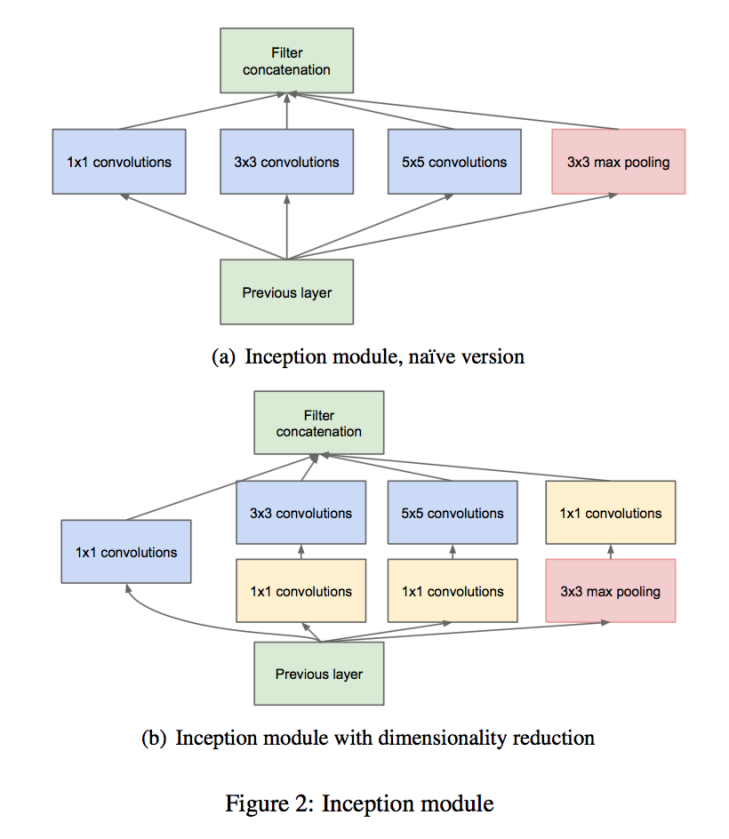


下面定义Inception的结构：

In [2]:
class Inception(nn.Module):
    def __init__(self,
                 ch_input, 
                 ch_1x1,
                 ch_3x3_reduce,
                 ch_3x3,
                 ch_5x5_reduce,
                 ch_5x5,
                 pool_proj):
        # 各个参数分别对应从左到右，关于通道数的变化的情况
        # reduce表示使用 1x1卷积 降低后的通道数
        super().__init__()
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(ch_input, ch_1x1, kernel_size=1),
            nn.ReLU(True)
        )
        
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(ch_input, ch_3x3_reduce, kernel_size=1),
            nn.ReLU(True),
            # 保持输出的分辨率不变
            nn.Conv2d(ch_3x3_reduce, ch_3x3, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(ch_input, ch_5x5_reduce, kernel_size=1),
            nn.ReLU(True),
            # 保持输出的分辨率不变
            nn.Conv2d(ch_5x5_reduce, ch_5x5, kernel_size=5, padding=2),
            nn.ReLU(True)
        )
        
        self.maxpool = nn.Sequential(
            # 注意，maxpool2d 中的 stride 默认是kernel_size
            # 这里使用了重叠池化，需要显式设置stride=1
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ch_input, pool_proj, kernel_size=1),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        a_out = self.conv_1x1(x)
        b_out = self.conv_3x3(x)
        c_out = self.conv_5x5(x)
        d_out = self.maxpool(x)
        # print(f"{a_out.shape} , {b_out.shape}, {c_out.shape}, {d_out.shape}")
        # 第0维度是 batch，第1维度是通道数，我们需要在通道数上拼接
        return torch.concat([a_out, b_out, c_out, d_out], dim=1)

# GoogLeNet的模型结构
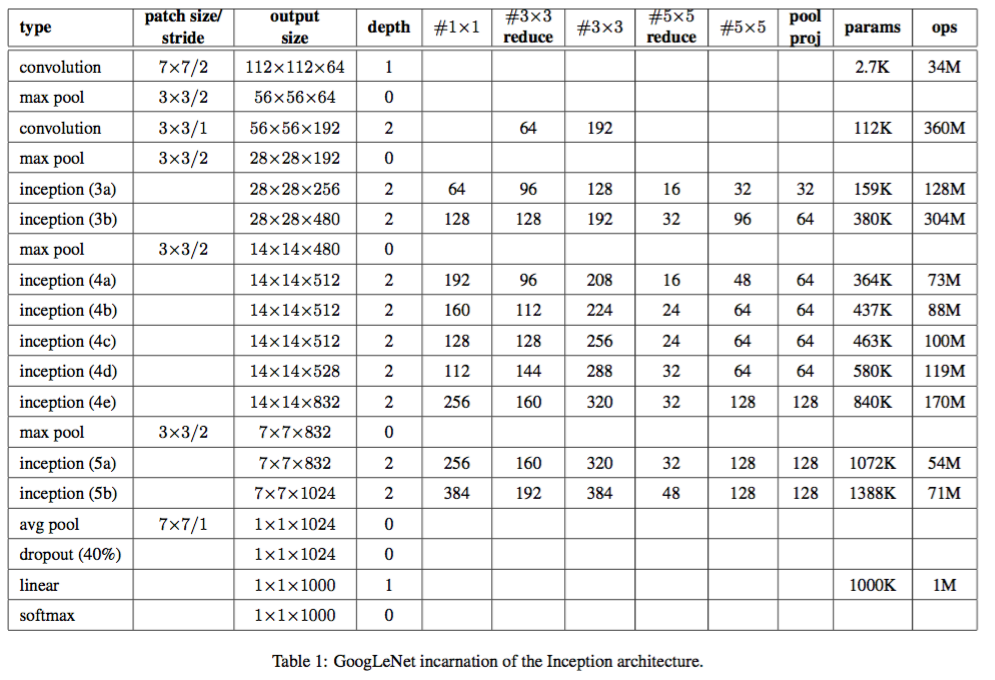

如表所示，这是 GoogLeNet 的结构。
通过卷积、池化以及和 Inception 模块的组合，形成了整个 GoogLeNet 模型。

如图所示，这是完整的GoogLeNet的图，与表相比需要注意的是多了两个辅助分类器（训练时作为主分类预测，同样去预测1000类，在推断时移除），训练时用，预测时不用，这里就不实现了；
同时还有LRN层，但是之前的VGG论文中提到过该标准化方法没啥用，这里的实现就不添加进去了。
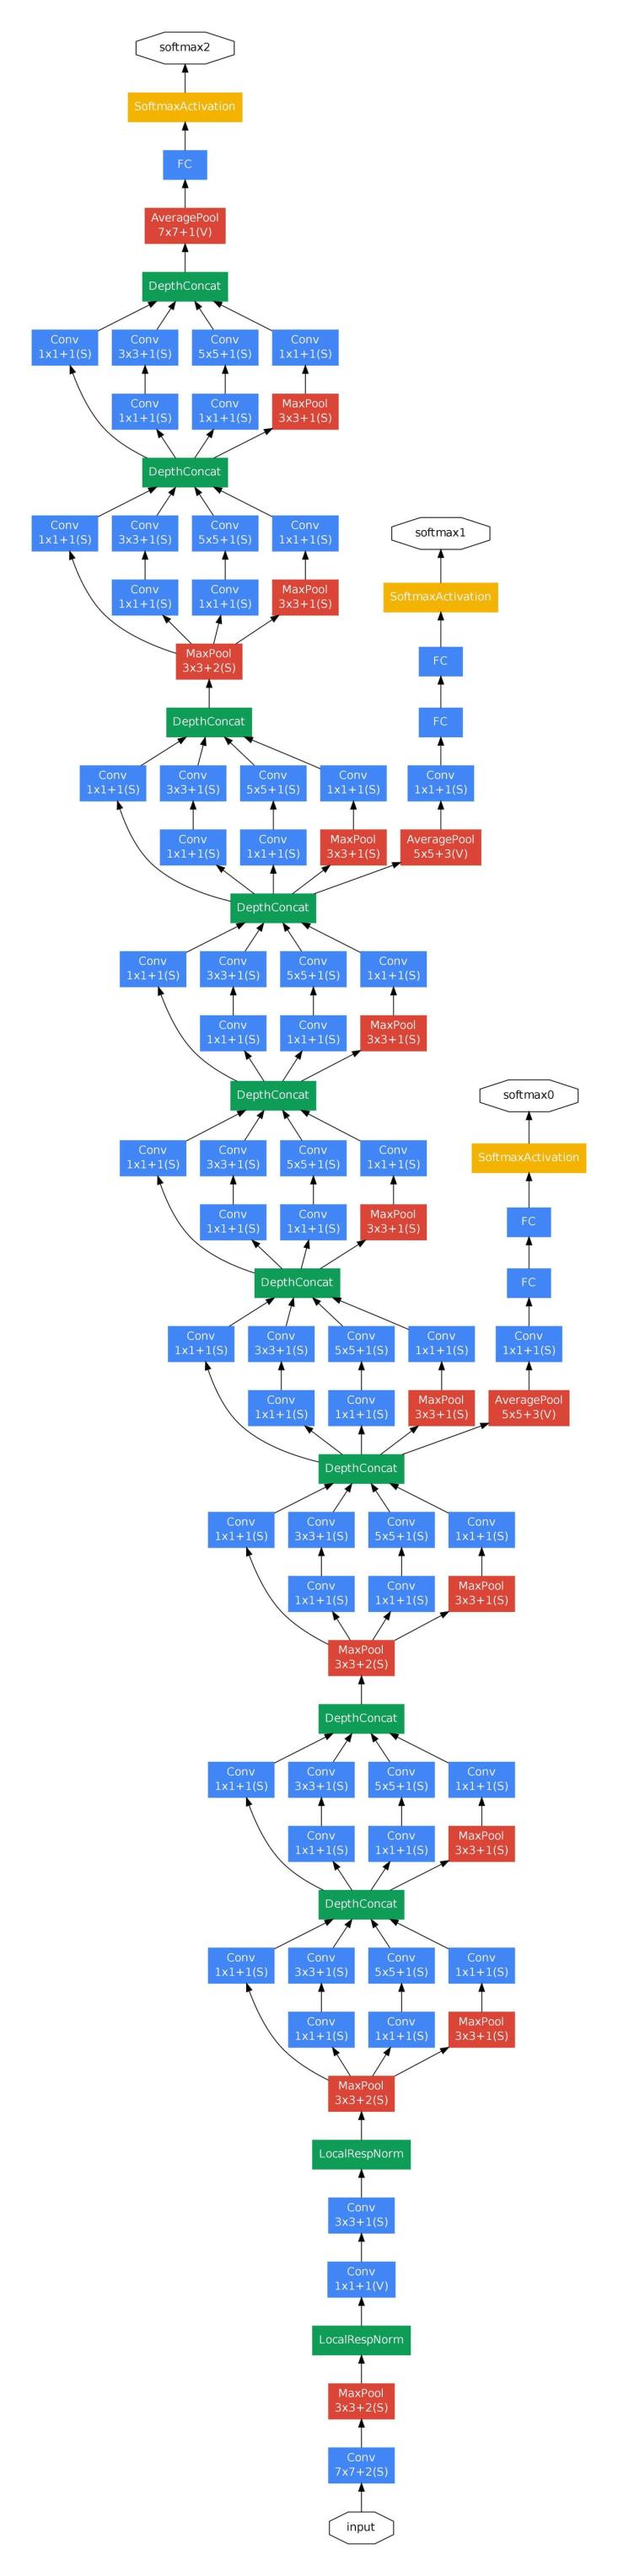

下面根据表和图实现GoogLeNet:

In [3]:
class MyGoogLenet(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.4):
        super().__init__()
        # input 224x224x3
        # output 112x112x64
        # (224 - 7 + 2*3 + 2) / 2 = 112
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(True)
        )
        
        # 56x56x64
        self.maxpool_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 看表格，需要使用1x1卷积 将 3x3 reduce 到 64
        # 应用3x3卷积输出 56x56x192
        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
        )
        
        # output 28x28x192
        self.maxpool_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # inception 3a，对着表格抄
        # output 28x28x256 (64 + 128 + 32 + 32 = 256)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        
        # output 28x28x480
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        
        # output 14x14x480
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # output 14x14x512
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 114, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        # output 7x7x832
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        # output 7x7x1024
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout_layer = nn.Dropout(dropout)
        
        self.linear_layer = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.maxpool_1(x)
        
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)
        
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.maxpool_4(x)
        
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        
        x = self.avg_pool(x)
        
        # Flatten 不作为网络的一层
        x = nn.Flatten()(x)
        
        x = self.dropout_layer(x)        
        
        x = self.linear_layer(x)
        
        return x

In [4]:
a = torch.rand((2, 3, 224, 224))

In [5]:
my_net = MyGoogLenet()
my_net(a).shape

torch.Size([2, 1000])

# torchvision中的实现

## Inception

首先来看 Inception 模块，torchvision 中的Inception 模块的实现如下：

```python
# 定义基本的Conv2d模块，减少代码冗余
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        # 加入了BN层，但原始的论文中是没有的
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class Inception(nn.Module):
    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
        conv_block: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1), conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        
        # 注意这个分支，原始论文中是5x5的，但是这里却变成了3x3
        # 打开对应的issue可以发现，这样实现是从 tensorflow 那边迁移过来的。
        # 作者推测5x5的计算量太大而降低为3x3。
        # 因为，按照VGG中的说法，一个5x5卷积可以使用两个3x3卷积替代，并能减少计算量
        # 但 TensorFlow 中的实现就是只有一个3x3，所以作者做了这样的推测。
        # 总之这里实现的 GoogLeNet 的 Inception 已经和原始论文中的不同了。
        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            # Here, kernel_size=3 instead of kernel_size=5 is a known bug.
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)
```

可以看到，在 torchvision 的实现中，代码和原始论文中的略有差异。主要是添加了BN层，以及Inception 模块中 5x5 卷积替换为了 3x3，可能是5x5卷积并不能带来比较好的结果，为了降低计算量使用3x3卷积，结果也差不多的原因，总之，和原始论文的实现有所差异。

## GoogLeNet
然后查看 torchvision 中的 GoogLeNet 的实现：

```python
class GoogLeNet(nn.Module):
    __constants__ = ["aux_logits", "transform_input"]

    def __init__(
        self,
        num_classes: int = 1000,
        aux_logits: bool = True,
        transform_input: bool = False,
        init_weights: Optional[bool] = None,
        blocks: Optional[List[Callable[..., nn.Module]]] = None,
        dropout: float = 0.2,
        dropout_aux: float = 0.7,
    ) -> None:
        super().__init__()
        # 用于debug，查看方法调用次数，默认关闭，没什么影响
        _log_api_usage_once(self)
        if blocks is None:
            # 列表中的三个元素，分别为：卷积（包含激活函数），Inception模块，辅助分类器输出
            blocks = [BasicConv2d, Inception, InceptionAux]
        if init_weights is None:
            warnings.warn(
                "The default weight initialization of GoogleNet will be changed in future releases of "
                "torchvision. If you wish to keep the old behavior (which leads to long initialization times"
                " due to scipy/scipy#11299), please set init_weights=True.",
                FutureWarning,
            )
            init_weights = True
        if len(blocks) != 3:
            raise ValueError(f"blocks length should be 3 instead of {len(blocks)}")
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]
        
        # 是否使用辅助分类器输出
        self.aux_logits = aux_logits
        # 这里transform就是将图像进行标准化操作
        self.transform_input = transform_input

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        # 这里的MaxPool2d实现和我的实现有所不同，
        # 为了满足高宽减半，我使用的是padding=1，而这里使用ceil_mode=True实现
        # 具体不同详见后边的小节介绍
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        # 这里不知道为什么，这里使用的是kernel_size=2，
        # 去查了一下TensorFlow中的实现，也是如此，见https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v1.py#L229
        # 因为torchvision中的实现是参考那边的，所以这里和tf中的实现一致也正常
        # 个人觉得这样操作影响不是很大，也有可能是写错了吧
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes, dropout=dropout_aux)
            self.aux2 = inception_aux_block(528, num_classes, dropout=dropout_aux)
        else:
            self.aux1 = None  # type: ignore[assignment]
            self.aux2 = None  # type: ignore[assignment]

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1: Optional[Tensor] = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2: Optional[Tensor] = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux2: Tensor, aux1: Optional[Tensor]) -> GoogLeNetOutputs:
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        else:
            return x  # type: ignore[return-value]

    def forward(self, x: Tensor) -> GoogLeNetOutputs:
        x = self._transform_input(x)
        x, aux1, aux2 = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted GoogleNet always returns GoogleNetOutputs Tuple")
            return GoogLeNetOutputs(x, aux2, aux1)
        else:
            return self.eager_outputs(x, aux2, aux1)
```

## 小结
总的来说，torchvision中实现的googlenet和原始论文中的有些差别，具体如下：
- Inception中使用了bn层，将其中的5x5卷积替换成了3x3卷积
- googlenet中的第4个池化层 self.maxpool4 使用的 kernel_size 变成了 3

# nn.MaxPool2d 中使用 ceil_mode 和 padding的区别

默认 ceil_mode 是向下取整，也就是说，只要滑动窗口，滑出界时，直接放弃。如果设置 ceil_mode 为True，那么会在滑动窗口画出界，但是不超过滑动窗口的一半时，直接好像在后边padding一样。

而使用padding，则和此前一样，直接在周围padding数字，那么就是按照正常的方式走。

------
一般我们使用 nn.MaxPool2d 最大池化来降低一半的分辨率。所以常设stride=2，而为了重叠池化（前边提到过重叠池化效果更好一些），则设置kernel_size=3。

nn.MaxPool2d 中使用 kernel_size=3，stride=2 的属性的情况下，
假设输入的分辨率为n，那么有输出： (n - kernel_size + stride + padding*2) / stride = (n-1+2*padding)/2。
如果padding=0,那么有：输出分辨率：(n-1)/2 （这里的除法不是python的除法，就是一般计算机中使用的除法，即计算结果直接去掉后边的小数）。
- 如果 n 是奇数，那么 ceil_mode 无用，因为算出的结果就是一个整数
- 如果 n 是偶数，那么 ceil_mode 的作用就可以体现了。假设n=4，那么 3/2 = 1，此时，输出不符合我们的要求（我们想要的是2x2的分辨率，高宽减半），所以设置 ceil_mode=True，向上取整，就可以得到 2 了；当然我们也可以设置ceil_mode=False（pytorch中默认Flase），padding=1，这样就是 (n+1)/2，对于n=4,就是2，也能得到2x2的分辨率。

举个例子：
如图所示：使用3x3的窗口，然后分别是 ceil_mode=True，和使用 padding=1 的对于4x4分辨率的池化：
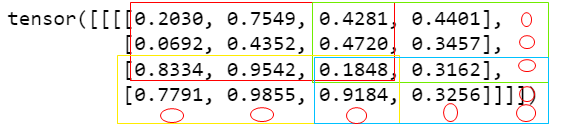
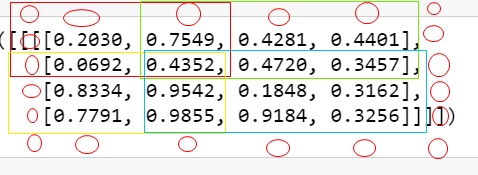

分别输出：
```
tensor([[[[0.9542, 0.4720],
          [0.9855, 0.9184]]]])
      
tensor([[[[0.7549, 0.7549],
          [0.9855, 0.9855]]]])
```

这两种方式都帮助我们输出想要的特征图形状，二者有些微小区别，但不知道哪个更好，因为我在torchvision源码中看到，这两种方式都有在使用。

- 方式1，使用ceil_mode=True
- 方式2，使用padding=1

使用方式1(ceil_mode=True)的网络：
1. squeezenet
2. googlenet

使用方式2(padding=1)的网络：
1. densenet
2. ssd
3. resnet
4. shufflenetv2

但是，我们可以从直观的感觉上看，使用ceil_mode模式，相当于是在特征图的右下方进行padding，图像采样的结果偏左上方，而使用padding的方式，相当于是在特征图的左上方进行padding，图像采样的结果偏右下方。不过话又说回来，就一个像素点的差别，应该不是很大，都可以吧。

In [6]:
x = torch.rand((1, 1, 4, 4))
m1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
m2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

In [7]:
a1 = m1(x)
a2 = m2(x)

In [8]:
x

tensor([[[[0.2162, 0.9451, 0.6491, 0.5784],
          [0.3328, 0.7799, 0.7873, 0.9432],
          [0.3469, 0.8537, 0.8330, 0.0297],
          [0.8935, 0.8452, 0.3558, 0.8436]]]])

In [9]:
a1

tensor([[[[0.9451, 0.9432],
          [0.8935, 0.8436]]]])

In [10]:
a2

tensor([[[[0.9451, 0.9451],
          [0.8935, 0.9432]]]])